In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import os
import pathlib
import hashlib
import PIL
import PIL.Image as Image
from fastai.vision.all import *
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# List physical devices and check if any GPUs are available and if required enable memory growth
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for GPU:", physical_devices[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")

Memory growth enabled for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
# Specify directory to retrieve images
data_dir = pathlib.Path('/content/drive/MyDrive/Nebulae')
data_folder = pathlib.Path('/content/drive/MyDrive/NewData')

In [ ]:
# Specify seed value
seed_value = 123
random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [ ]:
# Specify parameters
batch_size = 128
img_size = 224

In [ ]:
# Load dataset
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int', # Can also use categorical or binary
  color_mode='rgb',
  # batch_size=batch_size,
  image_size=(img_size, img_size),
  shuffle=True,
  seed=seed_value,
  validation_split=0.30,
  subset='both'
)

# Split loaded dataset to train and validation
ds_train, ds_validation = ds

Found 10119 files belonging to 5 classes.
Using 7084 files for training.
Using 3035 files for validation.


In [ ]:
# Split validation dataset to val and test data

val_batches = tf.data.experimental.cardinality(ds_validation)

# Convert val_batches to a Python integer before multiplication
test_ds = ds_validation.take(int(val_batches.numpy() * 0.4))
val_ds = ds_validation.skip(int(val_batches.numpy() * 0.4))

print(f"Number of training batches: {tf.data.experimental.cardinality(ds_train)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Number of training batches: 222
Number of validation batches: 57
Number of test batches: 38


In [ ]:
# Build model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding = 'same'),
    layers.Dropout(0.5),

    layers.Conv2D(32, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding = 'same'),
    layers.Dropout(0.5),

    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding = 'same'),
    layers.Dropout(0.5),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding = 'same'),
    layers.Dropout(0.5),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding = 'same'),
    layers.Dropout(0.5),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding = 'same'),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5)
])

# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early_stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
%%time

# Set up the log directory for TensorBoard
log_dir = os.path.join(data_folder, "logs", "fit", "run_" + str(int(time.time())))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Continue with model training using combined_ds_train
history = model.fit(ds_train,
                    shuffle = True,
                    # class_weight=cls_wgts_dict,
                    # batch_size=batch_size,
                    # steps_per_epoch = 70,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[early_stopping, tensorboard_callback])


Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.2125 - loss: 2.4965 - val_accuracy: 0.2001 - val_loss: 1.6139
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.2463 - loss: 1.6696 - val_accuracy: 0.2430 - val_loss: 1.5899
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.2783 - loss: 1.5825 - val_accuracy: 0.2567 - val_loss: 1.5831
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.3051 - loss: 1.5610 - val_accuracy: 0.2958 - val_loss: 1.5611
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.3371 - loss: 1.5255 - val_accuracy: 0.3266 - val_loss: 1.5622
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.3465 - loss: 1.4972 - val_accuracy: 0.3364 - val_loss: 1.5257
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.3436 - loss: 1.4801 - val_accuracy: 0.3128 - val_loss: 1.5215
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.3606 - l

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Obtain predictions for the validation dataset for further analysis
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.7372 - loss: 0.7705
Validation Loss: 0.7607126832008362
Validation Accuracy: 0.7487630844116211
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step


In [ ]:
# Extract actual labels from val_ds
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

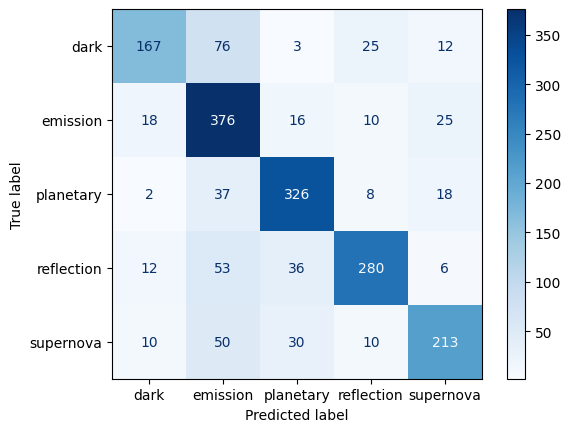

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

labels = ds_train.class_names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Create classification report
report = classification_report(y_true, y_pred_classes, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df)

              precision    recall  f1-score      support
dark           0.799043  0.590106  0.678862   283.000000
emission       0.635135  0.844944  0.725169   445.000000
planetary      0.793187  0.833760  0.812968   391.000000
reflection     0.840841  0.723514  0.777778   387.000000
supernova      0.777372  0.680511  0.725724   313.000000
accuracy       0.748763  0.748763  0.748763     0.748763
macro avg      0.769116  0.734567  0.744100  1819.000000
weighted avg   0.762850  0.748763  0.748125  1819.000000


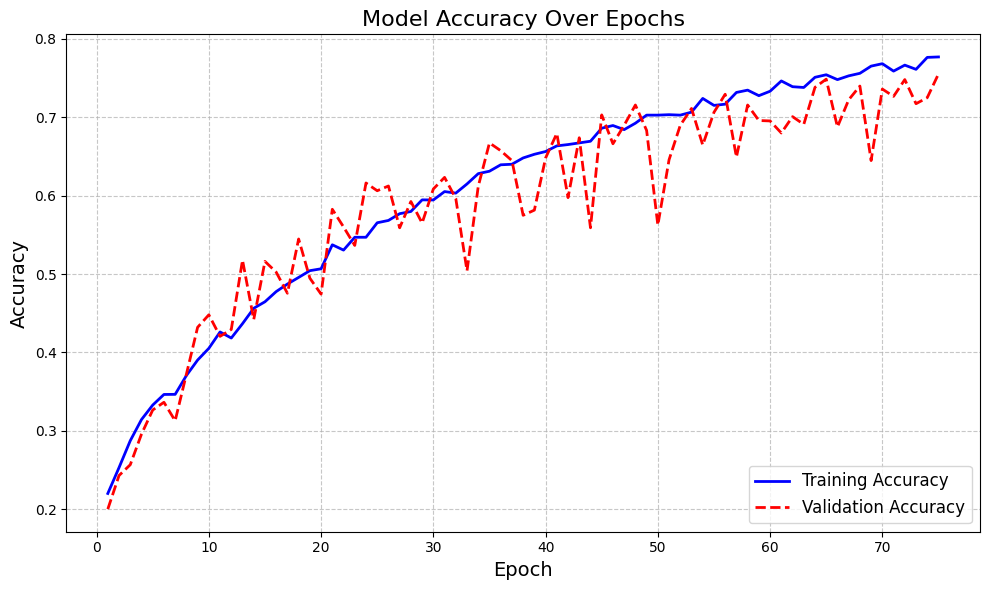

In [ ]:
# Plot accuracy scores for the model
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'],
         label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'],
         label='Validation Accuracy', color='red', linestyle='--', linewidth=2)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(data_folder / 'accuracy_plot_custom.png')
plt.show()

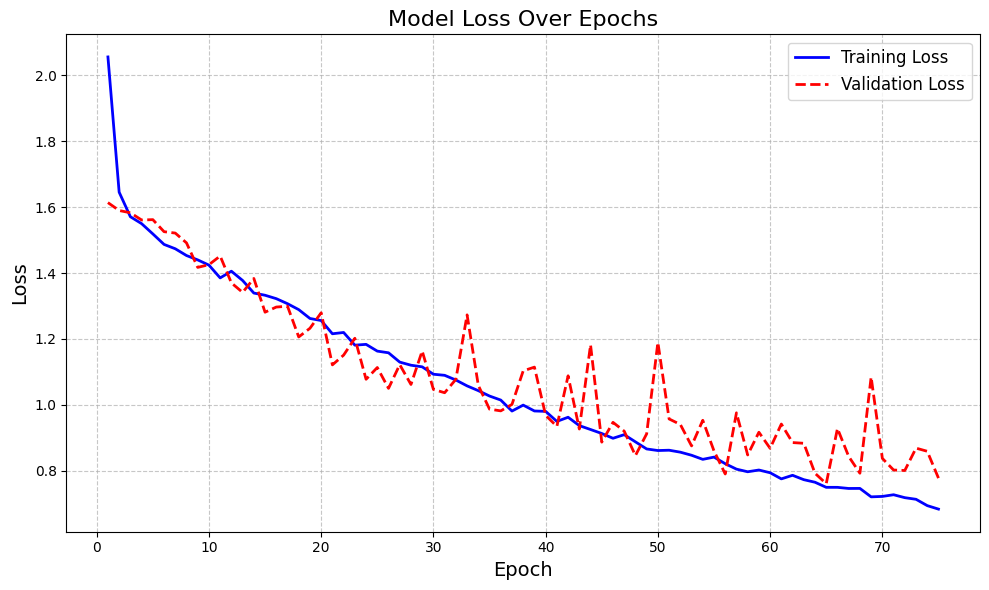

In [ ]:
# Plot training and validation loss for the model
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],
         label='Training Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],
         label='Validation Loss', color='red', linestyle='--', linewidth=2)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Model Loss Over Epochs', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(data_folder / 'loss_plot_custom.png')
plt.show()

In [ ]:
# Evaluate model using test scores
loss2, accuracy2 = model.evaluate(test_ds)
print("Test Loss:", loss2)
print("Test Accuracy:", accuracy2)

# Obtain predictions for the validation dataset for further analysis
y_pred_test = model.predict(test_ds)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7246 - loss: 0.8257
Test Loss: 0.7983775734901428
Test Accuracy: 0.7319079041481018
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step


In [ ]:
# Extract actual labels from test_ds
y_true_test = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

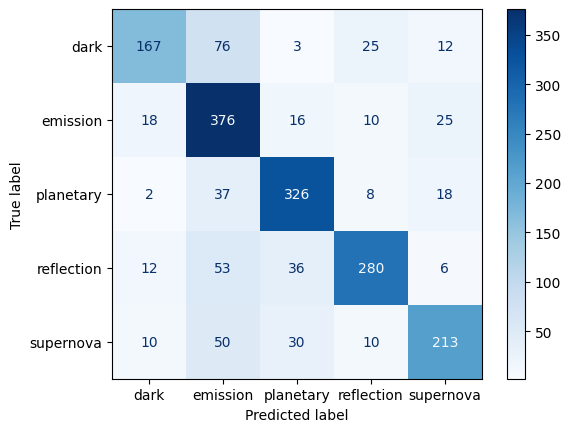

In [ ]:
# Create confusion matrix for test_ds
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

labels = ds_train.class_names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
# plt.savefig(data_folder / 'confusion_matrix_custom_test.png')
plt.show()

In [ ]:
# Create classification report
report_test = classification_report(y_true_test, y_pred_classes_test, target_names=labels, output_dict=True)
report_df_test = pd.DataFrame(report_test).transpose()

print(report_df_test)

              precision    recall  f1-score      support
dark           0.850649  0.629808  0.723757   208.000000
emission       0.583120  0.857143  0.694064   266.000000
planetary      0.797753  0.809886  0.803774   263.000000
reflection     0.798030  0.666667  0.726457   243.000000
supernova      0.776119  0.661017  0.713959   236.000000
accuracy       0.731908  0.731908  0.731908     0.731908
macro avg      0.761134  0.724904  0.732402  1216.000000
weighted avg   0.755707  0.731908  0.733206  1216.000000
